In [1]:
from qiskit import *
from qiskit.tools.visualization import array_to_latex , plot_histogram, plot_bloch_multivector
from math import pi
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.tools.monitor import job_monitor
from qiskit.extensions import Initialize
%matplotlib inline

In [2]:
IBMQ.save_account('bc198117720621ce2cefda12b1cf37946028d7cc2c6268b849ccebfc45a5495107087dc658b5b5b126029c6376b395d2ab21610dd03478183c4b0ce60f0d182f')


/tmp/ipykernel_24535/742870634.py:1: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.save_account('bc198117720621ce2cefda12b1cf37946028d7cc2c6268b849ccebfc45a5495107087dc658b5b5b126029c6376b395d2ab21610dd03478183c4b0ce60f0d182f')
/tmp/ipykernel_24535/742870634.py:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.save_account('bc198117720621ce2cefda12b1cf37946028

In [3]:
# Creating class and methods for both quantum simulators and real Quantum computers

class Simulators():

    def StateVectorSimulator(circuit):
        simulator = Aer.get_backend('statevector_simulator')
        statevector = execute(circuit, backend=simulator).result().get_statevector()
        return statevector

    def QasmSimulator(circuit, shots):
        simulator = Aer.get_backend('qasm_simulator')
        counts = execute(circuit, backend=simulator, shots=shots).result().get_counts()
        return counts

    def UnitarySimulator(circuit):
        simulator = Aer.get_backend('unitary_simulator')
        unitary = execute(circuit, backend=simulator).result().get_unitary()
        return unitary
    
class QuantumComputer():
    def __init__(self, name, circuit, shots):
        self.Quantum = name
        self.circuit = circuit
        self.shots = shots
        
    def RealQuantumComputer(self):
        provider = IBMQ.load_account()
        q_computer = provider.get_backend(self.Quantum)
        transpiled_circuit = transpile(self.circuit, q_computer)
        job = execute(transpiled_circuit, backend = q_computer, shots = self.shots)
        print(job.job_id())
        job_monitor(job)
        return job_monitor , job
    

## Simulator Version

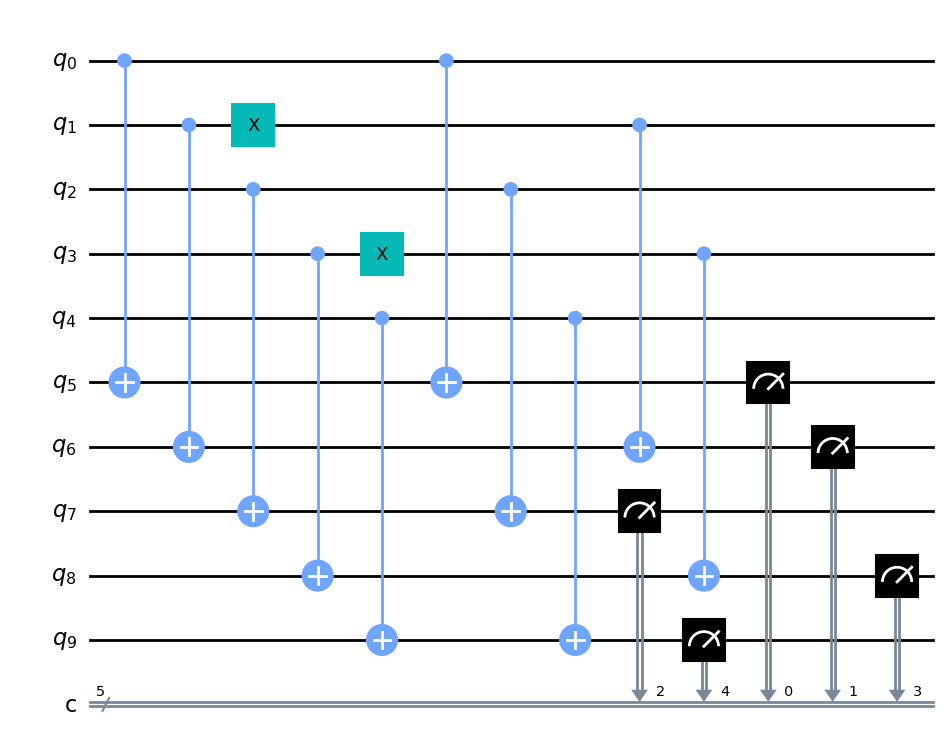

In [14]:
qc = QuantumCircuit(10,5) # creating  a  10 qubit circuit with 5 qubits and 5 ancillary qubits and 5 
# classical bits
qc.cx([0,1,2,3,4],[5,6,7,8,9]) # connecting the qubits with the ancillary bits
# introducing error on 2nd qubit and 4th qubit
qc.x(1)
qc.x(3)

qc.cx([0,1,2,3,4],[5,6,7,8,9])
qc.measure([5,6,7,8,9],[0,1,2,3,4]) #syndrome measurement
qc.draw('mpl')

In [23]:
syndromes = Simulators.QasmSimulator(qc,1024) # extracting syndromes for the error correction
print("Syndromes: ",syndromes)

Syndromes:  {'00000': 1024}


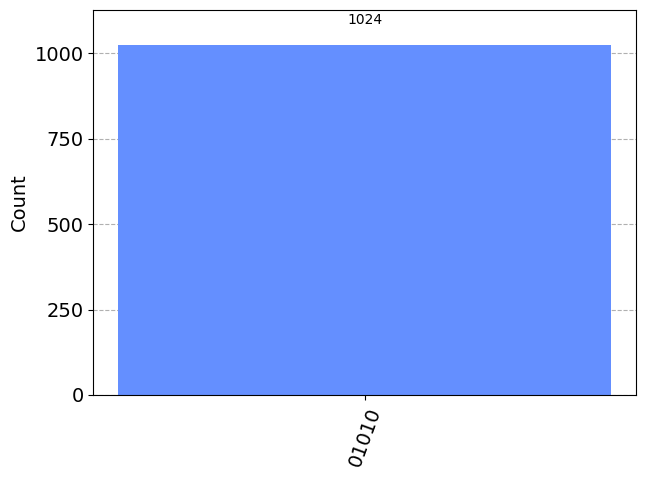

In [22]:
plot_histogram(syndromes)

In [16]:
# error corrections

most_frequent = syndromes.most_frequent() # taking the most frequent occurance and appending it to a list 
print(most_frequent)

error_bits = []

for i , j in enumerate(most_frequent):
    error_bits.append(int(j))
print(error_bits)

01010
[0, 1, 0, 1, 0]


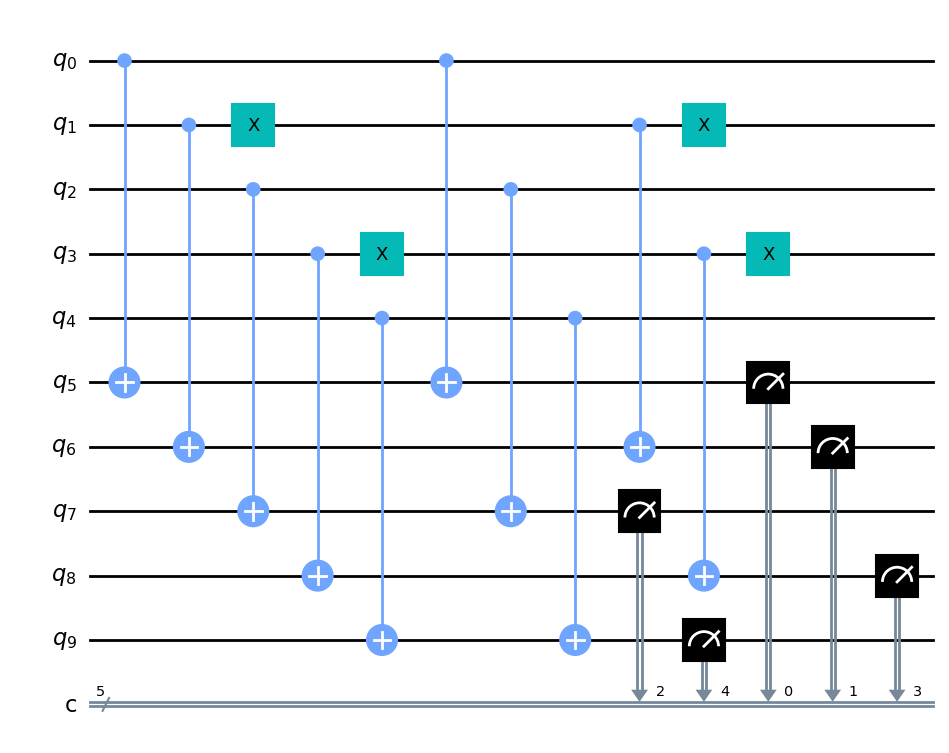

In [17]:
# correcting the error according to the syndrome result

for i in range(len(error_bits)):
    if error_bits[i] == 1:
        qc.x(i)
        
qc.draw('mpl')

In [19]:
qc.measure([0,1,2,3,4],[0,1,2,3,4])


corrected_meqasurements = Simulators.QasmSimulator(qc, 1024) # corrected masurement

In [24]:
print("Corrected measurement: ",corrected_meqasurements)

Corrected measurement:  {'00000': 1024}


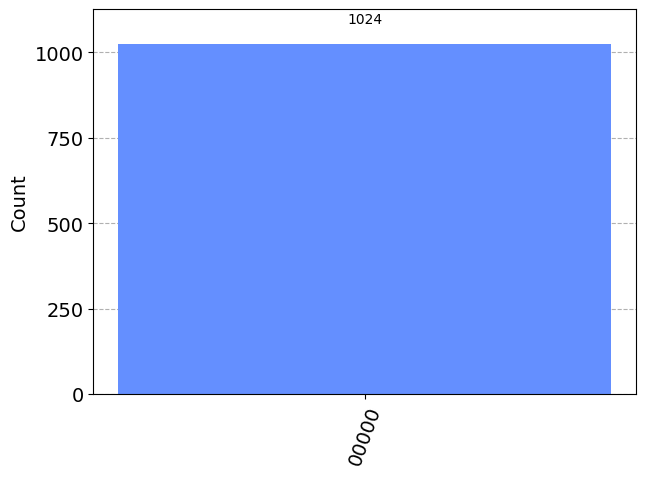

In [21]:
plot_histogram(corrected_meqasurements)

## Real Hardware 

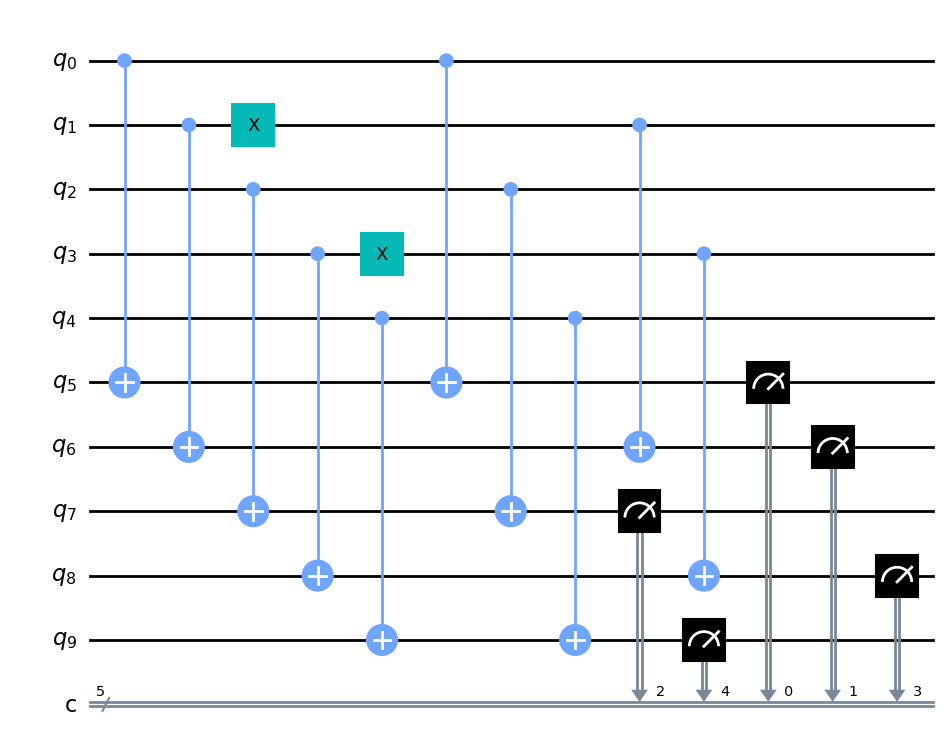

In [27]:
qc_r = QuantumCircuit(10,5) # creating  a  10 qubit circuit with 5 qubits and 5 ancillary qubits and 5 
# classical bits
qc_r.cx([0,1,2,3,4],[5,6,7,8,9]) # connecting the qubits with the ancillary bits
# introducing error on 2nd qubit and 4th qubit
qc_r.x(1)
qc_r.x(3)

qc_r.cx([0,1,2,3,4],[5,6,7,8,9])
qc_r.measure([5,6,7,8,9],[0,1,2,3,4]) #syndrome measurement
qc_r.draw('mpl')

In [28]:
real_hardware = QuantumComputer('ibm_osaka', qc_r, 1024)
job_monitor, job = real_hardware.RealQuantumComputer() # connecting to real hardware

ibmqfactory.load_account:WARNING:2023-12-07 16:02:43,194: Credentials are already in use. The existing account in the session will be replaced.


cnrysbdzeg00008v8m0g
Job Status: job has successfully run


In [29]:
job_result = job.result()
quantum_syndromes = job_result.get_counts(qc_r)

print(quantum_syndromes) # extracting the syndromes for error detection

{'11000': 3, '11110': 1, '01100': 2, '01010': 881, '11010': 10, '00010': 16, '01001': 1, '00011': 1, '01110': 15, '01011': 16, '01000': 78}


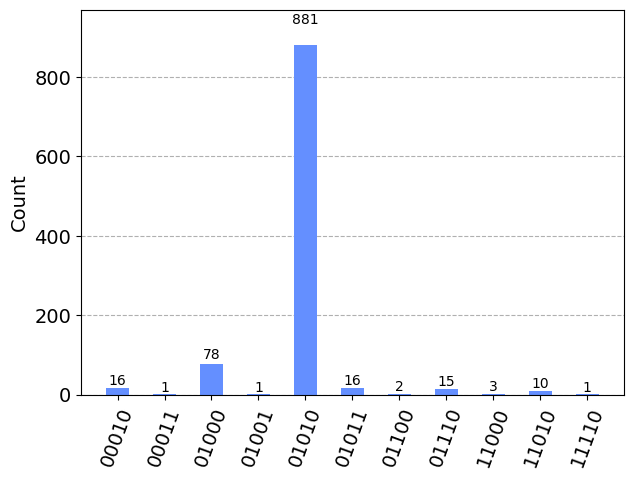

In [39]:
plot_histogram(quantum_syndromes)

In [30]:
quantum_most_frequent = quantum_syndromes.most_frequent()
print(quantum_most_frequent)  # taking the most frequent occuring error

01010


In [32]:
# error correction according to the syndrome measurement

quantum_error = []
for i ,j in enumerate(quantum_most_frequent):
    quantum_error.append(int(j))
    
print(quantum_error)

[0, 1, 0, 1, 0]


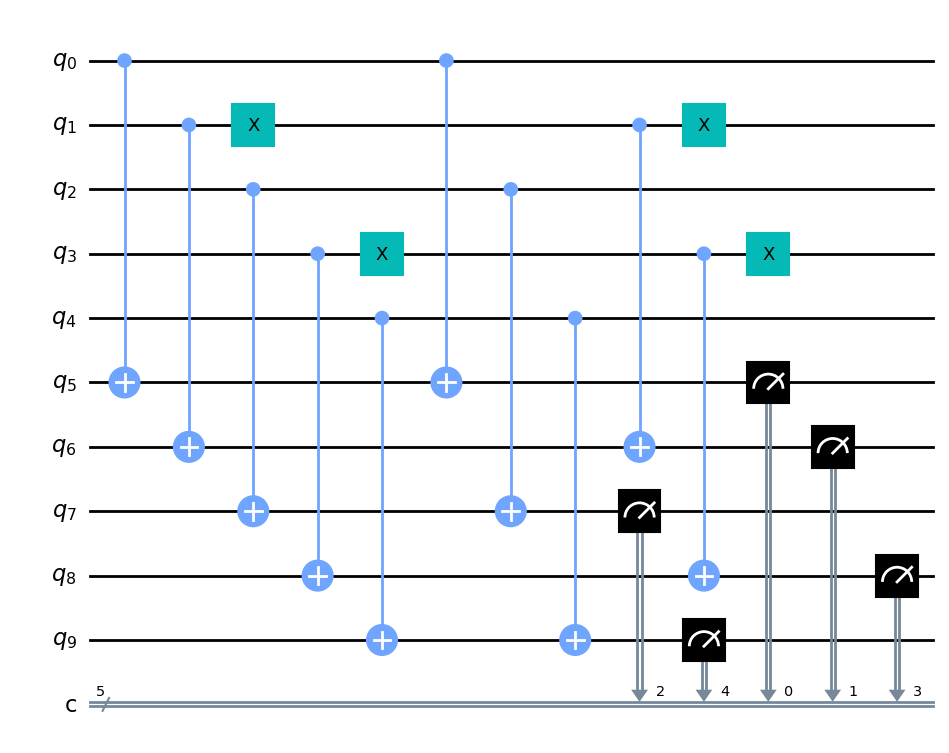

In [33]:
for i in range(len(quantum_error)):
    if quantum_error[i] == 1:
        qc_r.x(i)
        
qc_r.draw('mpl')

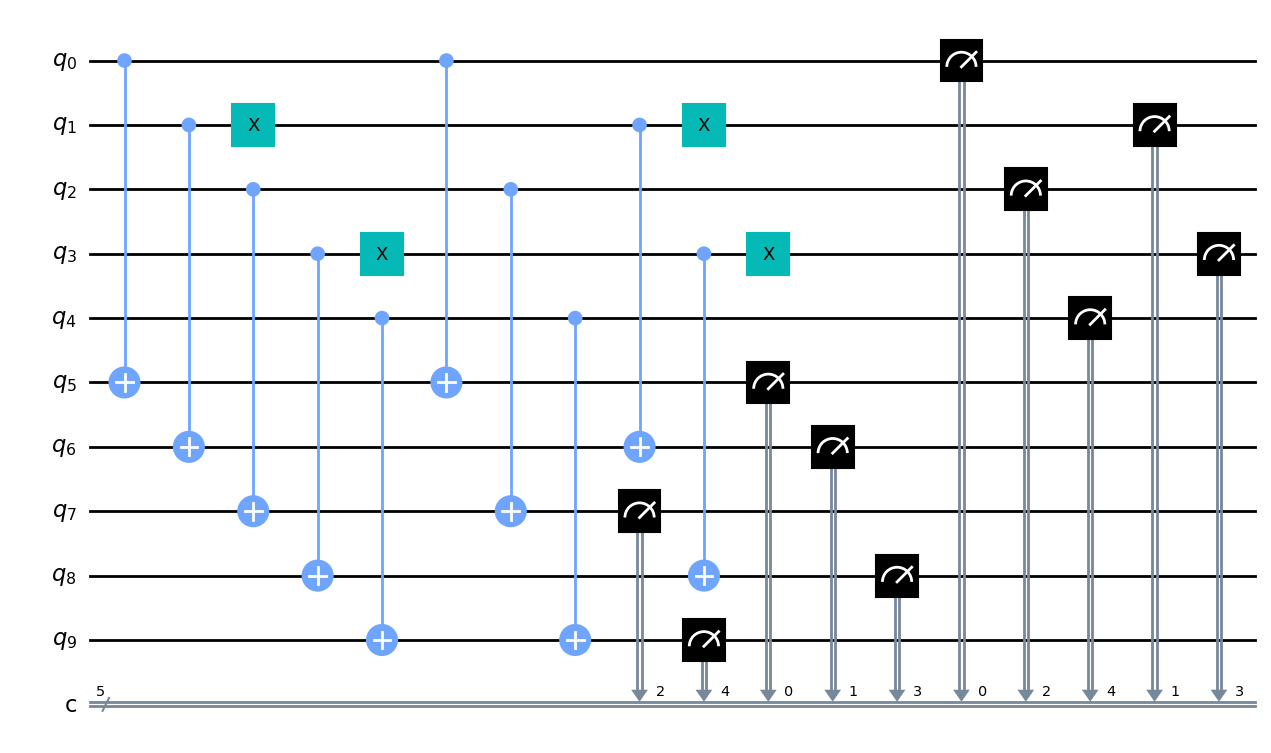

In [34]:
qc_r.measure([0,1,2,3,4],[0,1,2,3,4])

qc_r.draw('mpl')

In [35]:
real_hardware_2 = QuantumComputer('ibm_osaka', qc_r, 1024)
real_job_monitor, real_job = real_hardware_2.RealQuantumComputer()

ibmqfactory.load_account:WARNING:2023-12-07 17:01:27,409: Credentials are already in use. The existing account in the session will be replaced.


cnrzmw3gsbh0008sywvg
Job Status: job has successfully run


In [37]:
real_job_result = real_job.result()

corrected_counts = real_job_result.get_counts(qc_r)

print(corrected_counts)


{'00111': 12, '00001': 250, '10000': 4, '00010': 11, '10011': 1, '01000': 12, '10001': 3, '00000': 706, '01010': 1, '00101': 9, '10010': 1, '00011': 6, '00100': 7, '01001': 1}


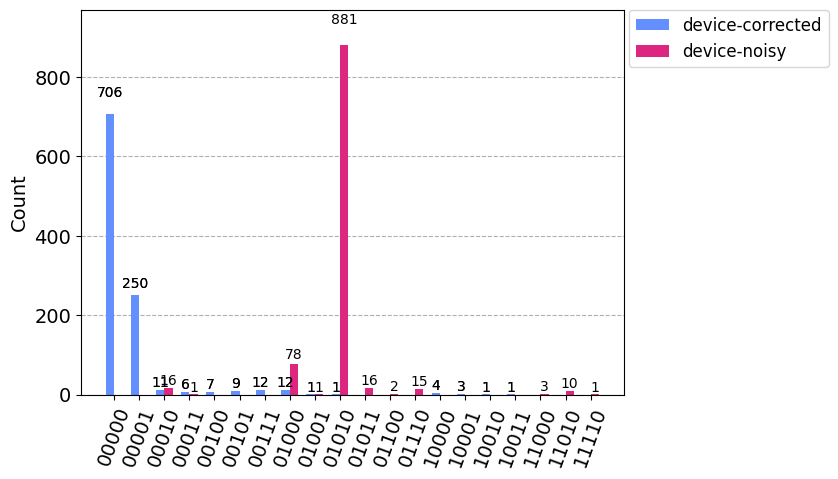

In [38]:
# Histogram of corrected error interestingly compared to the 3 qubit error correction here after correcting 
# the error a new error is created as 00001

plot_histogram([corrected_counts,quantum_syndromes],legend=['device-corrected', 'device-noisy']) 